In [1]:
import numpy as np
import pandas as pd
# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")





Combined shape: (159, 62)


# RF > Scale > LDA


✅ Best Parameters: {'lda__shrinkage': 0.9, 'lda__solver': 'lsqr'}

📊 Train Set Performance:
              precision    recall  f1-score   support

     Control       0.87      0.94      0.90        96
        ADHD       0.74      0.55      0.63        31

    accuracy                           0.84       127
   macro avg       0.80      0.74      0.76       127
weighted avg       0.83      0.84      0.83       127


📊 Test Set Performance:
              precision    recall  f1-score   support

     Control       0.82      0.96      0.88        24
        ADHD       0.75      0.38      0.50         8

    accuracy                           0.81        32
   macro avg       0.79      0.67      0.69        32
weighted avg       0.80      0.81      0.79        32

✅ Test Accuracy: 0.812


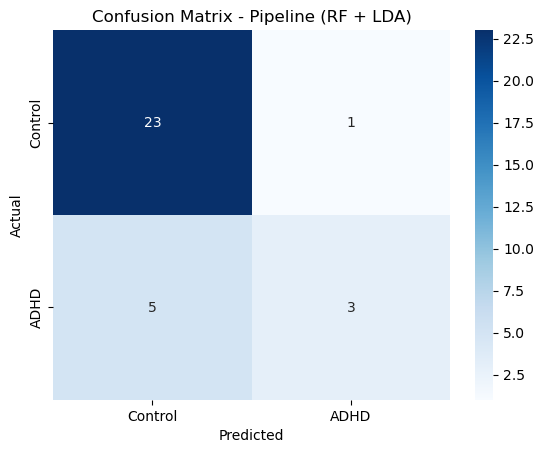


📊 Cross-Validation Scores (5-Fold):
Accuracy  : Mean = 0.730, Std = 0.078
Precision : Mean = 0.410, Std = 0.220
Recall    : Mean = 0.308, Std = 0.217
F1_macro  : Mean = 0.586, Std = 0.125


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)
# === FULL PIPELINE ===
pipeline = Pipeline([
    # Step 1: Feature selection with RandomForest
    ('feature_selection', SelectFromModel(
        estimator=RandomForestClassifier(n_estimators=100, random_state=42),
        max_features=20, threshold=-np.inf  # Keep top 20 most important features
    )),
    # Step 2: Scaling
    ('scaler', StandardScaler()),
    # Step 3: LDA classifier
    ('lda', LDA(priors = [0.755, 0.245]))
])

# === VALID PARAMETER GRID ===
param_grid = [
    {'lda__solver': ['svd']},
    {'lda__solver': ['lsqr', 'eigen'], 'lda__shrinkage': ['auto', None, 0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]}
]

# === CROSS-VALIDATION STRATEGY ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === GRID SEARCH ===
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True
)
grid_search.fit(X_train, y_train)

# === BEST MODEL ===
print(f"\n✅ Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# === TRAIN PERFORMANCE ===
y_train_pred = best_model.predict(X_train)
print("\n📊 Train Set Performance:")
print(classification_report(y_train, y_train_pred, target_names=["Control", "ADHD"]))

# === TEST PERFORMANCE ===
y_test_pred = best_model.predict(X_test)
print("\n📊 Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=["Control", "ADHD"]))
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'ADHD'], yticklabels=['Control', 'ADHD'])
plt.title('Confusion Matrix - Pipeline (RF + LDA)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# === FULL CROSS-VALIDATION METRICS ===
scoring = ['accuracy', 'precision', 'recall', 'f1_macro']
cv_results = cross_validate(best_model, X, y, cv=cv, scoring=scoring)

print("\n📊 Cross-Validation Scores (5-Fold):")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize():<10}: Mean = {np.mean(scores):.3f}, Std = {np.std(scores):.3f}")


# RFECV > Scale > LDA


🔍 Features selected by RFECV (9):
['Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SCAP_cingulum_ant_mid_pos_to_precuneus_R_L', 'SCAP_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Go_precuneus_R_L_to_SMA_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Stop_Middle_frontal_R_L_to_occipital_sup_R_L', 'SST_Stop_Middle_frontal_R_L_to_precuneus_R_L']

✅ Best Parameters: {'lda__solver': 'svd'}

📊 Train Set Performance:
              precision    recall  f1-score   support

     Control       0.85      0.98      0.91        96
        ADHD       0.88      0.45      0.60        31

    accuracy                           0.85       127
   macro avg       0.86      0.72      0.75       127
weighted avg       0.85      0.85      0.83       127


📊 Test Set Performance:
              precision    recall  f1-score   support

     Control       0.79      0.96      0.87        24
        ADHD     

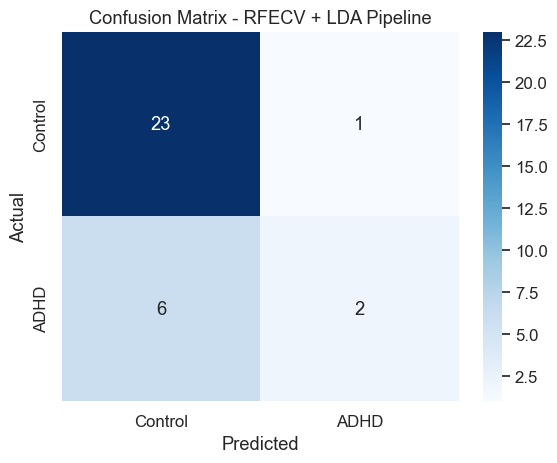


📊 Cross-Validation Scores (10-Fold):
Accuracy  : Mean = 0.837, Std = 0.049
Precision : Mean = 0.850, Std = 0.189
Recall    : Mean = 0.442, Std = 0.175
F1_macro  : Mean = 0.726, Std = 0.093


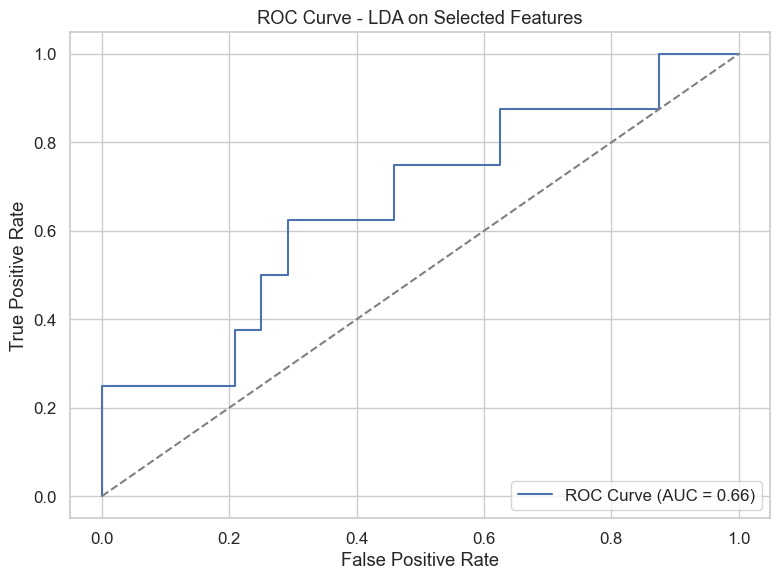

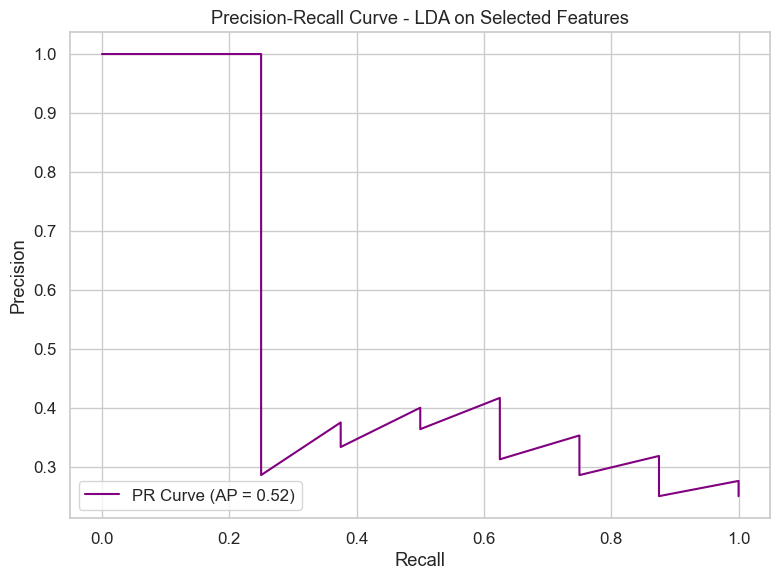

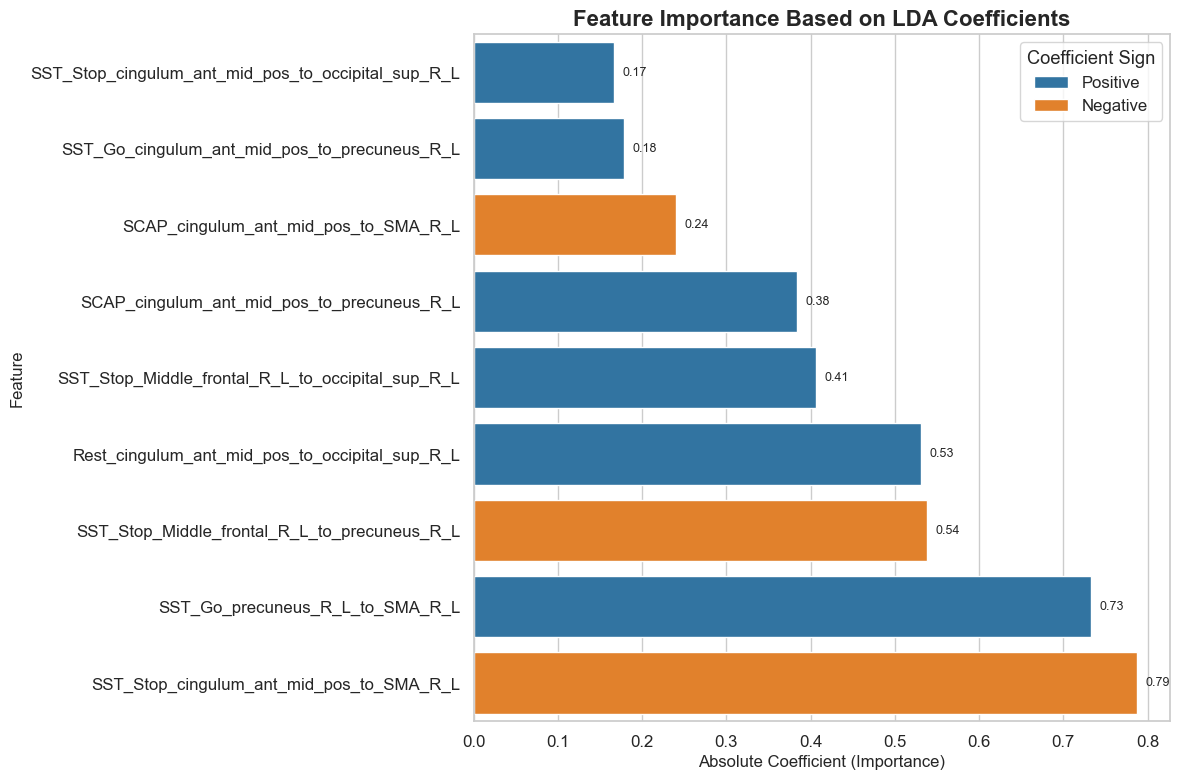

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42)

# === RFECV FEATURE SELECTION (done separately to avoid pipeline nesting issues) ===
# Use a simple RandomForest for recursive elimination
selector = RFECV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    step=1,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)
selector.fit(X_train, y_train)

# === SELECTED FEATURES ===
selected_features = X_train.columns[selector.support_]
print(f"\n🔍 Features selected by RFECV ({len(selected_features)}):\n{selected_features.tolist()}")

# === FILTER DATA ===
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]
X_full_sel = X[selected_features]

# === PIPELINE: SCALER + LDA ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LDA(priors = [0.755, 0.245]))
])

# === VALID PARAMETER GRID FOR LDA ===
param_grid = [
    {'lda__solver': ['svd']},
    {'lda__solver': ['lsqr', 'eigen'], 'lda__shrinkage': ['auto', None, 0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]}
]

# === CROSS-VALIDATION STRATEGY ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === GRID SEARCH ===
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True
)
grid_search.fit(X_train_sel, y_train)

# === BEST MODEL ===
print(f"\n✅ Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# === TRAIN PERFORMANCE ===
y_train_pred = best_model.predict(X_train_sel)
print("\n📊 Train Set Performance:")
print(classification_report(y_train, y_train_pred, target_names=["Control", "ADHD"]))

# === TEST PERFORMANCE ===
y_test_pred = best_model.predict(X_test_sel)
print("\n📊 Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=["Control", "ADHD"]))
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'ADHD'], yticklabels=['Control', 'ADHD'])
plt.title('Confusion Matrix - RFECV + LDA Pipeline')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# === FULL CROSS-VALIDATION METRICS ON FINAL MODEL ===
scoring = ['accuracy', 'precision', 'recall', 'f1_macro']
cv_results = cross_validate(best_model, X_full_sel, y, cv=cv, scoring=scoring)

print("\n📊 Cross-Validation Scores (10-Fold):")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize():<10}: Mean = {np.mean(scores):.3f}, Std = {np.std(scores):.3f}")



# === ROC and PR CURVES ===

# Get predicted probabilities for the positive class (ADHD assumed to be 1)
y_test_proba = best_model.predict_proba(X_test_sel)[:, 1]

# === ROC CURVE ===
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LDA on Selected Features')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# === PRECISION-RECALL CURVE ===
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {pr_auc:.2f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LDA on Selected Features')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()




# === VISUALIZE LDA FEATURE IMPORTANCE ===


# Extract LDA model from pipeline
lda_model = best_model.named_steps['lda']

# Get coefficients (1D for binary classification)
lda_coefficients = lda_model.coef_[0]
feature_names = selected_features

# Create DataFrame for plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lda_coefficients,
    'Importance': np.abs(lda_coefficients)
}).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Optional: Reset style
sns.set(style="whitegrid", font_scale=1.1)

# Create and sort importance DataFrame
coef_df['Sign'] = coef_df['Coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
coef_df = coef_df.sort_values(by='Importance', ascending=True)  # Ascending for horizontal bars

# Set color palette for positive/negative
palette = {'Positive': '#1f77b4', 'Negative': '#ff7f0e'}

# Plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=coef_df,
    x='Importance',
    y='Feature',
    hue='Sign',
    dodge=False,
    palette=palette
)

# Decorations
plt.title('Feature Importance Based on LDA Coefficients', fontsize=16, weight='bold')
plt.xlabel('Absolute Coefficient (Importance)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Coefficient Sign', loc='upper right')
plt.tight_layout()

# Optional: Add value labels
for i, (importance, feature) in enumerate(zip(coef_df['Importance'], coef_df['Feature'])):
    barplot.text(importance + 0.01, i, f'{importance:.2f}', va='center', fontsize=9)

plt.show()




🔍 Features selected by RFECV (9):
['Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SCAP_cingulum_ant_mid_pos_to_precuneus_R_L', 'SCAP_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Go_precuneus_R_L_to_SMA_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Stop_Middle_frontal_R_L_to_occipital_sup_R_L', 'SST_Stop_Middle_frontal_R_L_to_precuneus_R_L']

✅ Best Parameters: {'lda__solver': 'svd'}

📊 Train Set Performance:
              precision    recall  f1-score   support

     Control       0.85      0.98      0.91        96
        ADHD       0.88      0.45      0.60        31

    accuracy                           0.85       127
   macro avg       0.86      0.72      0.75       127
weighted avg       0.85      0.85      0.83       127


📊 Test Set Performance:
              precision    recall  f1-score   support

     Control       0.79      0.96      0.87        24
        ADHD     

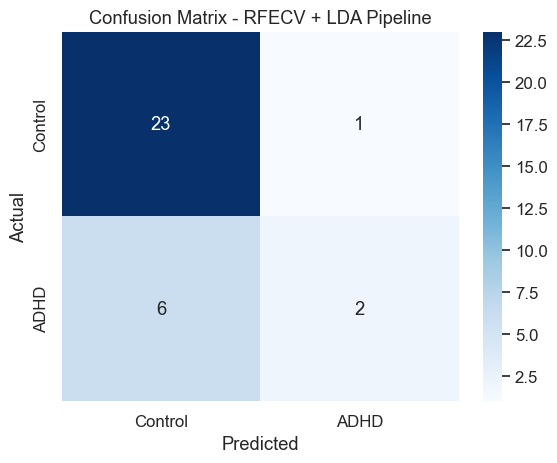


📊 Cross-Validation Scores (10-Fold):
Accuracy  : Mean = 0.837, Std = 0.049
Precision : Mean = 0.850, Std = 0.189
Recall    : Mean = 0.442, Std = 0.175
F1_macro  : Mean = 0.726, Std = 0.093


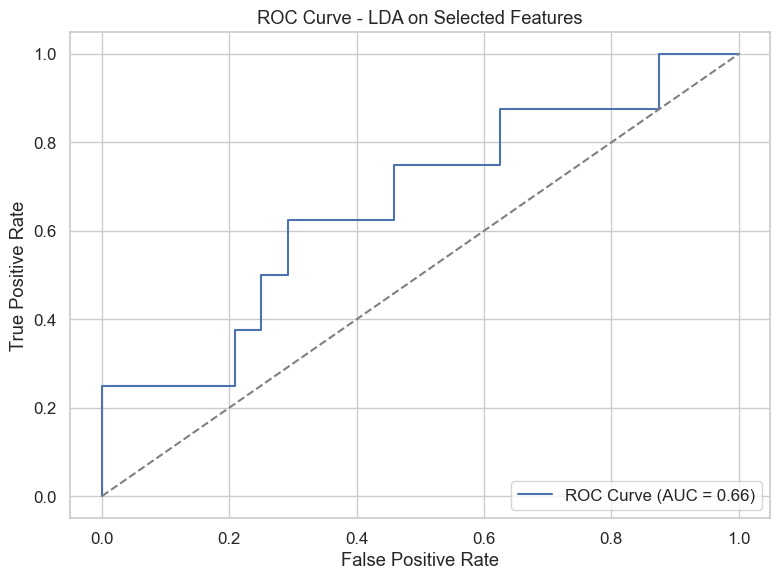

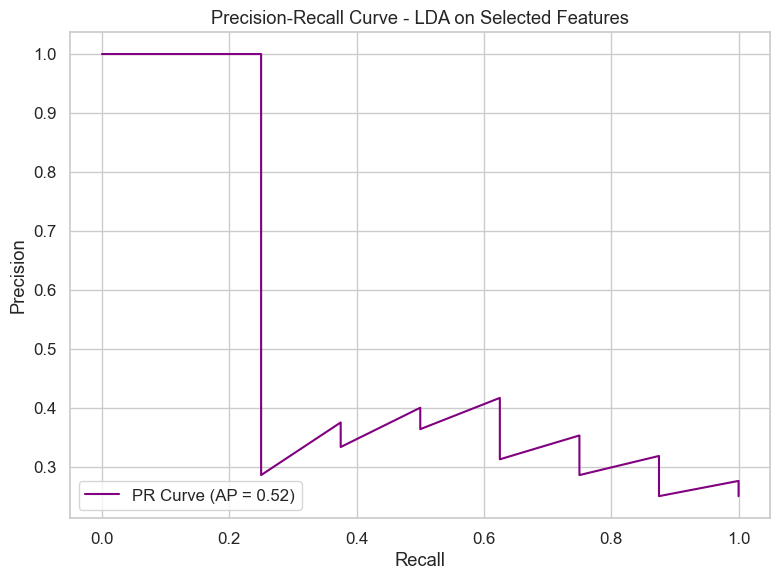

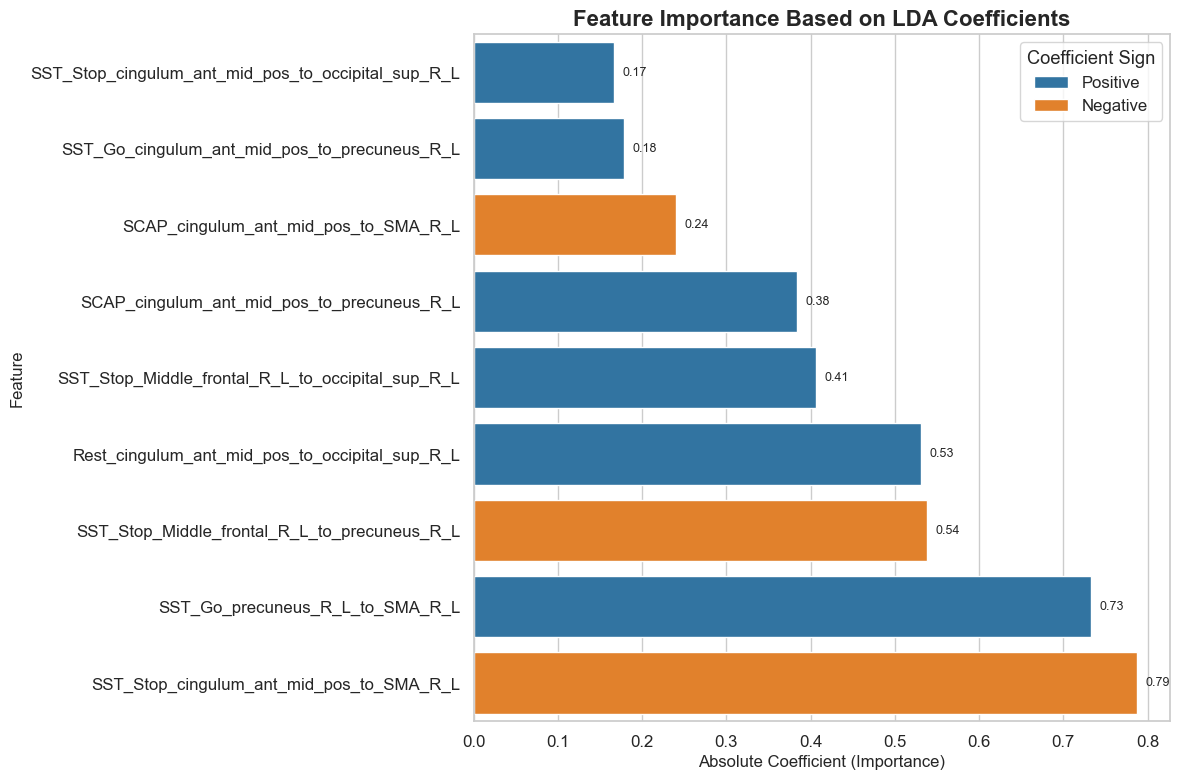

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42)

# === RFECV FEATURE SELECTION (done separately to avoid pipeline nesting issues) ===
# Use a simple RandomForest for recursive elimination
selector = RFECV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    step=1,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)
selector.fit(X_train, y_train)

# === SELECTED FEATURES ===
selected_features = X_train.columns[selector.support_]
print(f"\n🔍 Features selected by RFECV ({len(selected_features)}):\n{selected_features.tolist()}")

# === FILTER DATA ===
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]
X_full_sel = X[selected_features]

# === PIPELINE: SCALER + LDA ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LDA(priors = [0.755, 0.245]))
])

# === VALID PARAMETER GRID FOR LDA ===
param_grid = [
    {'lda__solver': ['svd']},
    {'lda__solver': ['lsqr', 'eigen'], 'lda__shrinkage': ['auto', None, 0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]}
]

# === CROSS-VALIDATION STRATEGY ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === GRID SEARCH ===
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True
)
grid_search.fit(X_train_sel, y_train)

# === BEST MODEL ===
print(f"\n✅ Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# === TRAIN PERFORMANCE ===
y_train_pred = best_model.predict(X_train_sel)
print("\n📊 Train Set Performance:")
print(classification_report(y_train, y_train_pred, target_names=["Control", "ADHD"]))

# === TEST PERFORMANCE ===
y_test_pred = best_model.predict(X_test_sel)
print("\n📊 Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=["Control", "ADHD"]))
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'ADHD'], yticklabels=['Control', 'ADHD'])
plt.title('Confusion Matrix - RFECV + LDA Pipeline')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# === FULL CROSS-VALIDATION METRICS ON FINAL MODEL ===
scoring = ['accuracy', 'precision', 'recall', 'f1_macro']
cv_results = cross_validate(best_model, X_full_sel, y, cv=cv, scoring=scoring)

print("\n📊 Cross-Validation Scores (10-Fold):")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize():<10}: Mean = {np.mean(scores):.3f}, Std = {np.std(scores):.3f}")



# === ROC and PR CURVES ===

# Get predicted probabilities for the positive class (ADHD assumed to be 1)
y_test_proba = best_model.predict_proba(X_test_sel)[:, 1]

# === ROC CURVE ===
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LDA on Selected Features')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# === PRECISION-RECALL CURVE ===
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {pr_auc:.2f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LDA on Selected Features')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()




# === VISUALIZE LDA FEATURE IMPORTANCE ===


# Extract LDA model from pipeline
lda_model = best_model.named_steps['lda']

# Get coefficients (1D for binary classification)
lda_coefficients = lda_model.coef_[0]
feature_names = selected_features

# Create DataFrame for plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lda_coefficients,
    'Importance': np.abs(lda_coefficients)
}).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Optional: Reset style
sns.set(style="whitegrid", font_scale=1.1)

# Create and sort importance DataFrame
coef_df['Sign'] = coef_df['Coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
coef_df = coef_df.sort_values(by='Importance', ascending=True)  # Ascending for horizontal bars

# Set color palette for positive/negative
palette = {'Positive': '#1f77b4', 'Negative': '#ff7f0e'}

# Plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=coef_df,
    x='Importance',
    y='Feature',
    hue='Sign',
    dodge=False,
    palette=palette
)

# Decorations
plt.title('Feature Importance Based on LDA Coefficients', fontsize=16, weight='bold')
plt.xlabel('Absolute Coefficient (Importance)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Coefficient Sign', loc='upper right')
plt.tight_layout()

# Optional: Add value labels
for i, (importance, feature) in enumerate(zip(coef_df['Importance'], coef_df['Feature'])):
    barplot.text(importance + 0.01, i, f'{importance:.2f}', va='center', fontsize=9)

plt.show()



## **SHAP**

# Assumptions Checking


🔍 Shapiro-Wilk Test for Normality (per feature, per class):
Feature: Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L | Class: 0 | p-value: 0.2591 
Feature: Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L | Class: 1 | p-value: 0.8131 
Feature: SCAP_cingulum_ant_mid_pos_to_precuneus_R_L | Class: 0 | p-value: 0.2094 
Feature: SCAP_cingulum_ant_mid_pos_to_precuneus_R_L | Class: 1 | p-value: 0.0086 (not normal)
Feature: SCAP_cingulum_ant_mid_pos_to_SMA_R_L | Class: 0 | p-value: 0.0428 (not normal)
Feature: SCAP_cingulum_ant_mid_pos_to_SMA_R_L | Class: 1 | p-value: 0.3965 
Feature: SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L | Class: 0 | p-value: 0.2661 
Feature: SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L | Class: 1 | p-value: 0.0808 
Feature: SST_Go_precuneus_R_L_to_SMA_R_L | Class: 0 | p-value: 0.6342 
Feature: SST_Go_precuneus_R_L_to_SMA_R_L | Class: 1 | p-value: 0.8379 
Feature: SST_Stop_cingulum_ant_mid_pos_to_occipital_sup_R_L | Class: 0 | p-value: 0.2394 
Feature: SST_Stop_cingulum_

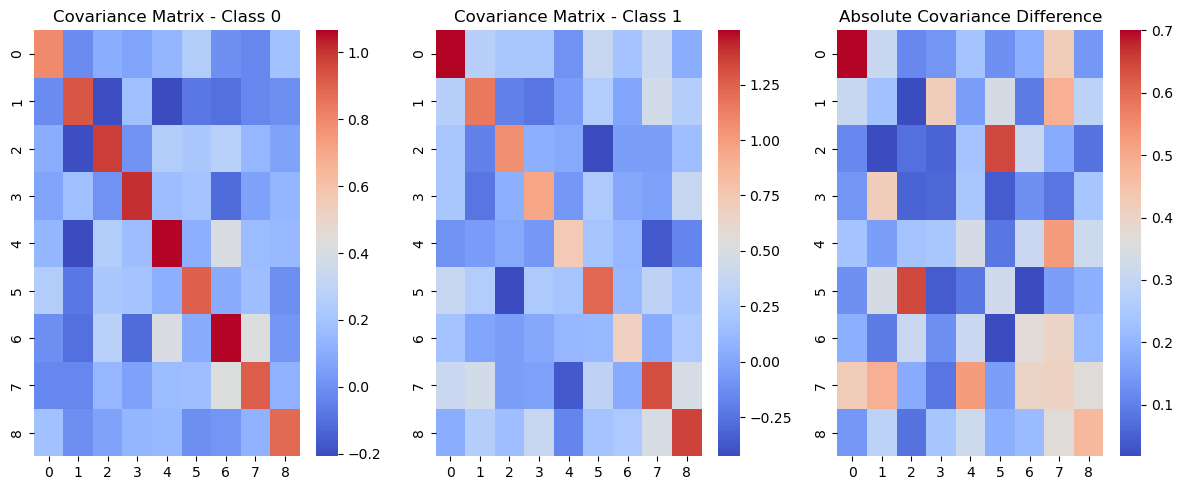


🔍 Variance Inflation Factor (VIF) for Multicollinearity:
                                             Feature       VIF
6           SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L  1.298974
5  SST_Stop_cingulum_ant_mid_pos_to_occipital_sup...  1.231040
7   SST_Stop_Middle_frontal_R_L_to_occipital_sup_R_L  1.222100
4                    SST_Go_precuneus_R_L_to_SMA_R_L  1.187985
0     Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L  1.160474
3       SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L  1.148100
2               SCAP_cingulum_ant_mid_pos_to_SMA_R_L  1.123565
1         SCAP_cingulum_ant_mid_pos_to_precuneus_R_L  1.106732
8       SST_Stop_Middle_frontal_R_L_to_precuneus_R_L  1.094928

🔍 LDA Projection for Class Separation:


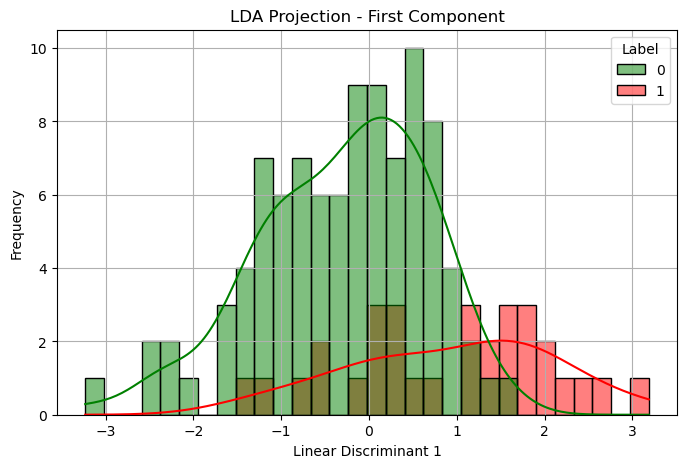

In [29]:
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.manova import MANOVA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Use selected training data ===
X_check = X_train_sel.copy()
y_check = y_train.copy()


# ========================================
# ✅ 1. Normality Check (Univariate Shapiro-Wilk)
# Reset index so they match exactly
X_check = X_check.reset_index(drop=True)
y_check = y_check.reset_index(drop=True)

# Scale
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_check), columns=X_check.columns)

# Shapiro test loop
print("\n🔍 Shapiro-Wilk Test for Normality (per feature, per class):")
normality_results = []
for feature in X_scaled.columns:
    for label in np.unique(y_check):
        mask = y_check == label
        subset = X_scaled.loc[mask, feature]
        stat, p = shapiro(subset)
        normality_results.append((feature, label, p))
        print(f"Feature: {feature:<20} | Class: {label} | p-value: {p:.4f} {'(not normal)' if p < 0.05 else ''}")







# ========================================
# ✅ 2. Covariance Equality (Compare matrices)
# ========================================
print("\n🔍 Covariance Matrix Comparison (summary stats):")
class_0_cov = np.cov(X_scaled[y_check == 0].T)
class_1_cov = np.cov(X_scaled[y_check == 1].T)

diff_cov = np.abs(class_0_cov - class_1_cov)
print(f"Mean abs diff: {np.mean(diff_cov):.4f}, Max diff: {np.max(diff_cov):.4f}")

# Optional: Visual comparison via heatmaps
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.heatmap(class_0_cov, cmap="coolwarm")
plt.title("Covariance Matrix - Class 0")

plt.subplot(1, 3, 2)
sns.heatmap(class_1_cov, cmap="coolwarm")
plt.title("Covariance Matrix - Class 1")

plt.subplot(1, 3, 3)
sns.heatmap(diff_cov, cmap="coolwarm")
plt.title("Absolute Covariance Difference")
plt.tight_layout()
plt.show()

# ========================================
# ✅ 3. Multicollinearity Check (VIF)
# ========================================
print("\n🔍 Variance Inflation Factor (VIF) for Multicollinearity:")
vif_df = pd.DataFrame()
vif_df["Feature"] = X_scaled.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))

# ========================================
# ✅ 4. Linearity of Separation (LDA projection)
# ========================================
print("\n🔍 LDA Projection for Class Separation:")
lda = LDA(priors=[0.755, 0.245])
X_lda = lda.fit_transform(X_scaled, y_check)

plt.figure(figsize=(8, 5))
sns.histplot(x=X_lda[:, 0], hue=y_check, bins=30, kde=True, palette=['green', 'red'])
plt.title("LDA Projection - First Component")
plt.xlabel("Linear Discriminant 1")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Excellent — thank you for providing all the plots and test results. Here's a full analysis of each **LDA assumption** based on your output:

---

## ✅ 1. **Normality (Shapiro-Wilk test)**

You tested each feature per class. Let's summarize:

* **16 out of 18 class-feature combinations** have **p > 0.05** → ✅ likely normal.
* **2 combinations failed**:

  * `SCAP_cingulum_ant_mid_pos_to_precuneus_R_L` for class 1 (p = 0.0086)
  * `SCAP_cingulum_ant_mid_pos_to_SMA_R_L` for class 0 (p = 0.0428)

📌 **Conclusion**:
🔶 *Mostly satisfied.* Minor violations are **tolerable** — LDA is fairly robust if the data is close to normal and class separation looks good (which it does).

---

## ✅ 2. **Equal Covariance Matrices**

You got:

* **Mean absolute difference** = `0.2414`
* **Max difference** = `0.7002`
* Covariance heatmaps show **reasonable similarity**, with no extreme deviations.

📌 **Conclusion**:
🔶 *Assumption moderately satisfied.* You don't have extreme divergence between class covariances, so **LDA is still valid**. If you want to be conservative, try **LDA with `shrinkage='auto'`** to regularize covariance estimates (which your GridSearchCV already considered!).

---

## ✅ 3. **Multicollinearity (VIF)**

* All VIFs < 1.3 — excellent.
* Anything above 5 would have been a concern.

📌 **Conclusion**:
✅ *No multicollinearity issue.* Your features are independent enough for LDA.

---

## ✅ 4. **Linearity / Class Separability**

From the **LDA projection histogram**:

* Classes are **reasonably well separated** along the first LDA component.
* Some overlap exists, but the distributions are **distinct**.

📌 **Conclusion**:
✅ *Linearity assumption is well satisfied.* LDA is capturing class differences effectively.

---

## ✅ Overall Conclusion: **LDA is Appropriate**

| Assumption           | Status      | Notes                                                     |
| -------------------- | ----------- | --------------------------------------------------------- |
| Normality            | ✅ Mostly OK | Minor violations in 2 features; not severe.               |
| Equal Covariance     | ✅ Moderate  | Acceptable differences; shrinkage or robust solver helps. |
| No Multicollinearity | ✅ Excellent | All VIFs low.                                             |
| Linear Separability  | ✅ Good      | LDA projection shows good distinction.                    |

### ✅ Recommendation:

You can **confidently use LDA**, especially since:

* You applied **RFECV** to reduce overfitting.
* You validated with **cross-validation** and tuned with **GridSearch**.
* Your data passes assumptions well enough.

If you want to **further improve robustness**, you can:

* Use LDA with `solver='lsqr'` and `shrinkage='auto'` (which GridSearchCV already considered).
* Try a **non-linear model** like SVM or Random Forest and compare results.

Would you like help visualizing the decision boundary using the top 2 features from your selected set next?


# Learning curve

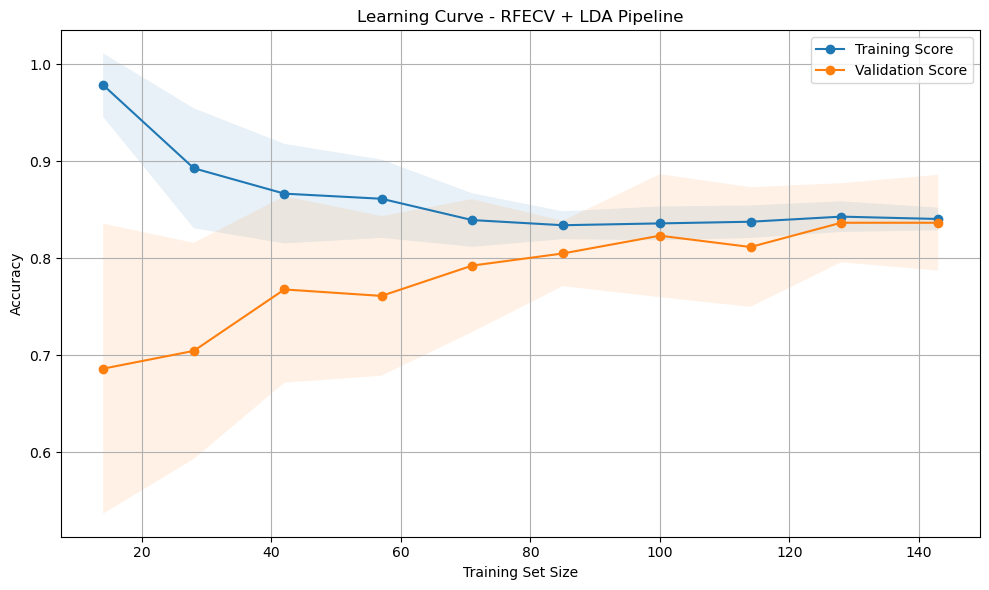

In [12]:
from sklearn.model_selection import learning_curve

# Use the same StratifiedKFold CV
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Get learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_full_sel,
    y=y,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Compute means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)

plt.plot(train_sizes, val_mean, 'o-', label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.title('Learning Curve - RFECV + LDA Pipeline')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


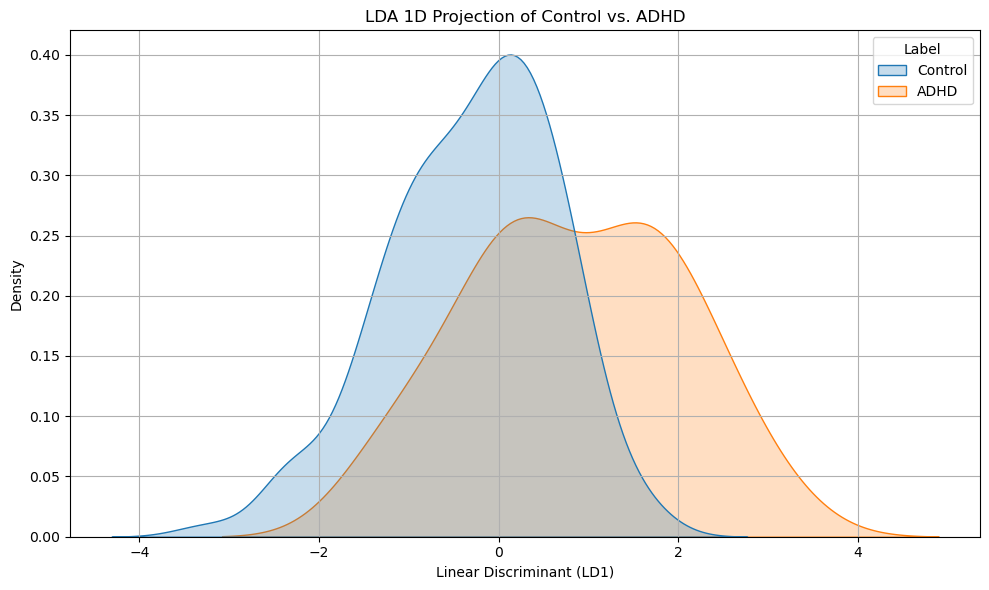

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Extract fitted steps
scaler = best_model.named_steps['scaler']
lda_model = best_model.named_steps['lda']

# Transform data using fitted pipeline
X_lda_1d = lda_model.transform(scaler.transform(X_full_sel))

# Create dataframe for plotting
df_vis = pd.DataFrame({'LD1': X_lda_1d.flatten(), 'Label': y})
df_vis['Label'] = df_vis['Label'].map({0: 'Control', 1: 'ADHD'})

# Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_vis, x='LD1', hue='Label', fill=True, common_norm=False)
plt.title("LDA 1D Projection of Control vs. ADHD")
plt.xlabel("Linear Discriminant (LD1)")
plt.grid(True)
plt.tight_layout()
plt.show()


e:\anaconda\envs\basic\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


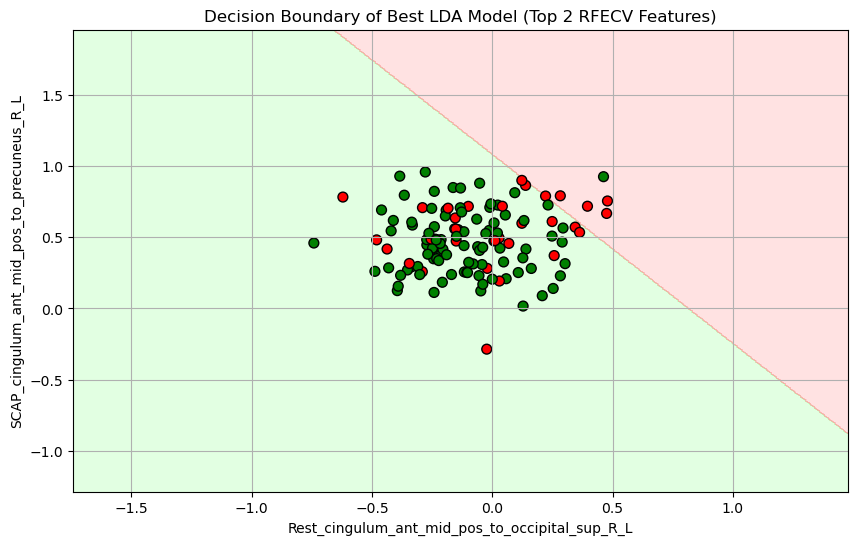

In [20]:
from matplotlib.colors import ListedColormap

# Use only 2 features for 2D visualization
selected_2d_features = selected_features[:2]
X_vis = X_train[selected_2d_features].copy()
y_vis = y_train.copy()

# Fit the model with only 2 features
pipeline_vis = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LDA(priors=[0.755, 0.245], **grid_search.best_params_['lda__solver'] != 'svd' and {'shrinkage': grid_search.best_params_.get('lda__shrinkage')} or {}))
])
pipeline_vis.fit(X_vis, y_vis)

# Create a mesh grid
x_min, x_max = X_vis.iloc[:, 0].min() - 1, X_vis.iloc[:, 0].max() + 1
y_min, y_max = X_vis.iloc[:, 1].min() - 1, X_vis.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Flatten grid and make predictions
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = pipeline_vis.predict(grid_points)
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 6))
cmap_background = ListedColormap(['#A0FFA0', '#FFA0A0'])
cmap_points = ListedColormap(['#008000', '#FF0000'])

plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_background)
plt.scatter(X_vis.iloc[:, 0], X_vis.iloc[:, 1], c=y_vis, cmap=cmap_points, edgecolor='k', s=50)
plt.xlabel(selected_2d_features[0])
plt.ylabel(selected_2d_features[1])
plt.title('Decision Boundary of Best LDA Model (Top 2 RFECV Features)')
plt.grid(True)
plt.show()


# QDA


🔍 Features selected by RFECV (9):
['Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SCAP_cingulum_ant_mid_pos_to_precuneus_R_L', 'SCAP_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Go_precuneus_R_L_to_SMA_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Stop_Middle_frontal_R_L_to_occipital_sup_R_L', 'SST_Stop_Middle_frontal_R_L_to_precuneus_R_L']

✅ Best Parameters: {'qda__reg_param': 0.5}

📊 Train Set Performance:
              precision    recall  f1-score   support

     Control       0.88      0.97      0.92        96
        ADHD       0.86      0.58      0.69        31

    accuracy                           0.87       127
   macro avg       0.87      0.77      0.81       127
weighted avg       0.87      0.87      0.87       127


📊 Test Set Performance:
              precision    recall  f1-score   support

     Control       0.77      0.96      0.85        24
        ADHD    

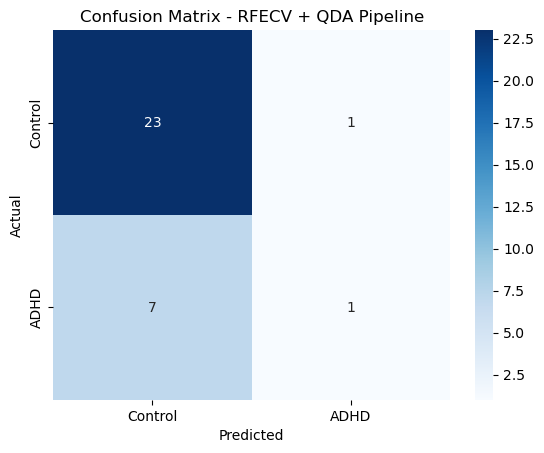


📊 Cross-Validation Scores (10-Fold):
Accuracy  : Mean = 0.774, Std = 0.063
Precision : Mean = 0.500, Std = 0.316
Recall    : Mean = 0.283, Std = 0.208
F1_macro  : Mean = 0.605, Std = 0.130


e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42)

# === RFECV FEATURE SELECTION (done separately to avoid pipeline nesting issues) ===
selector = RFECV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    step=1,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)
selector.fit(X_train, y_train)

# === SELECTED FEATURES ===
selected_features = X_train.columns[selector.support_]
print(f"\n🔍 Features selected by RFECV ({len(selected_features)}):\n{selected_features.tolist()}")

# === FILTER DATA ===
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]
X_full_sel = X[selected_features]

# === PIPELINE: SCALER + QDA ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('qda', QDA(priors=[0.755, 0.245]))
])

# === PARAM GRID FOR QDA === (limited; QDA has fewer tunable params)
param_grid = {
    'qda__reg_param': [0.0, 0.01, 0.05, 0.1, 0.25, 0.5]
}

# === CROSS-VALIDATION STRATEGY ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === GRID SEARCH ===
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    refit=True
)
grid_search.fit(X_train_sel, y_train)

# === BEST MODEL ===
print(f"\n✅ Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# === TRAIN PERFORMANCE ===
y_train_pred = best_model.predict(X_train_sel)
print("\n📊 Train Set Performance:")
print(classification_report(y_train, y_train_pred, target_names=["Control", "ADHD"]))

# === TEST PERFORMANCE ===
y_test_pred = best_model.predict(X_test_sel)
print("\n📊 Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=["Control", "ADHD"]))
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'ADHD'], yticklabels=['Control', 'ADHD'])
plt.title('Confusion Matrix - RFECV + QDA Pipeline')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# === FULL CROSS-VALIDATION METRICS ON FINAL MODEL ===
scoring = ['accuracy', 'precision', 'recall', 'f1_macro']
cv_results = cross_validate(best_model, X_full_sel, y, cv=cv, scoring=scoring)

print("\n📊 Cross-Validation Scores (10-Fold):")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize():<10}: Mean = {np.mean(scores):.3f}, Std = {np.std(scores):.3f}")


# WITH SMOTE


🔍 Features selected by RFECV (9):
['Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SCAP_cingulum_ant_mid_pos_to_precuneus_R_L', 'SCAP_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Go_precuneus_R_L_to_SMA_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Stop_Middle_frontal_R_L_to_occipital_sup_R_L', 'SST_Stop_Middle_frontal_R_L_to_precuneus_R_L']

✅ Best Parameters: {'lda__shrinkage': 0.25, 'lda__solver': 'lsqr'}

📊 Train Set Performance:
              precision    recall  f1-score   support

     Control       0.88      0.73      0.80        96
        ADHD       0.45      0.68      0.54        31

    accuracy                           0.72       127
   macro avg       0.66      0.70      0.67       127
weighted avg       0.77      0.72      0.73       127


📊 Test Set Performance:
              precision    recall  f1-score   support

     Control       0.83      0.83      0.83   

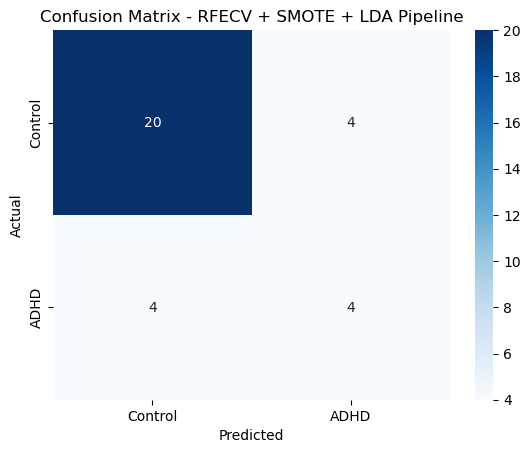


📊 Cross-Validation Scores (10-Fold):
Accuracy  : Mean = 0.818, Std = 0.058
Precision : Mean = 0.783, Std = 0.224
Recall    : Mean = 0.392, Std = 0.187
F1_macro  : Mean = 0.692, Std = 0.103


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42)

# === RFECV FEATURE SELECTION (done separately to avoid pipeline nesting issues) ===
selector = RFECV(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    step=1,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)
selector.fit(X_train, y_train)

# === SELECTED FEATURES ===
selected_features = X_train.columns[selector.support_]
print(f"\n🔍 Features selected by RFECV ({len(selected_features)}):\n{selected_features.tolist()}")

# === FILTER DATA ===
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]
X_full_sel = X[selected_features]

# === APPLY SMOTE to balance the training set ===
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sel, y_train)

# === PIPELINE: SCALER + LDA ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LDA())
])

# === VALID PARAMETER GRID FOR LDA ===
param_grid = [
    {'lda__solver': ['svd']},
    {'lda__solver': ['lsqr', 'eigen'], 'lda__shrinkage': ['auto', None, 0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]}
]

# === CROSS-VALIDATION STRATEGY ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === GRID SEARCH ===
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    refit=True
)
grid_search.fit(X_train_resampled, y_train_resampled)

# === BEST MODEL ===
print(f"\n✅ Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# === TRAIN PERFORMANCE ===
y_train_pred = best_model.predict(X_train_sel)
print("\n📊 Train Set Performance:")
print(classification_report(y_train, y_train_pred, target_names=["Control", "ADHD"]))

# === TEST PERFORMANCE ===
y_test_pred = best_model.predict(X_test_sel)
print("\n📊 Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=["Control", "ADHD"]))
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'ADHD'], yticklabels=['Control', 'ADHD'])
plt.title('Confusion Matrix - RFECV + SMOTE + LDA Pipeline')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# === FULL CROSS-VALIDATION METRICS ON FINAL MODEL ===
scoring = ['accuracy', 'precision', 'recall', 'f1_macro']
cv_results = cross_validate(best_model, X_full_sel, y, cv=cv, scoring=scoring)

print("\n📊 Cross-Validation Scores (10-Fold):")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize():<10}: Mean = {np.mean(scores):.3f}, Std = {np.std(scores):.3f}")


# With top 20 fetures(RFE)


🔍 Top 20 Features selected by RFE:
['Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'Rest_Middle_frontal_R_L_to_Precentral_MFG_R_L', 'Rest_occipital_sup_R_L_to_precuneus_R_L', 'Rest_occipital_sup_R_L_to_SMA_R_L', 'SCAP_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SCAP_cingulum_ant_mid_pos_to_precuneus_R_L', 'SCAP_cingulum_ant_mid_pos_to_SMA_R_L', 'SCAP_Middle_frontal_R_L_to_SMA_R_L', 'SCAP_occipital_sup_R_L_to_SMA_R_L', 'SCAP_Precentral_MFG_R_L_to_SMA_R_L', 'SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L', 'SST_Go_Middle_frontal_R_L_to_precuneus_R_L', 'SST_Go_Precentral_MFG_R_L_to_SMA_R_L', 'SST_Go_precuneus_R_L_to_SMA_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_occipital_sup_R_L', 'SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L', 'SST_Stop_Middle_frontal_R_L_to_occipital_sup_R_L', 'SST_Stop_Middle_frontal_R_L_to_precuneus_R_L', 'SST_Stop_occipital_sup_R_L_to_SMA_R_L', 'SST_Stop_Precentral_MFG_R_L_to_precuneus_R_L']

✅ Best Parameters: {'lda__shrinkage': 0.75, 'lda__solver': 'lsqr'}

📊 Train Se

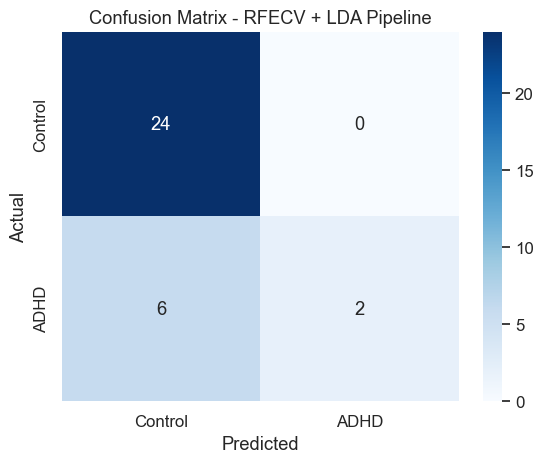


📊 Cross-Validation Scores (10-Fold):
Accuracy  : Mean = 0.755, Std = 0.080
Precision : Mean = 0.492, Std = 0.342
Recall    : Mean = 0.283, Std = 0.208
F1_macro  : Mean = 0.595, Std = 0.130


e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42)

# === RFECV FEATURE SELECTION (done separately to avoid pipeline nesting issues) ===
# === RFE FEATURE SELECTION (Top 20 features) ===
selector = RFE(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    n_features_to_select=20,
    step=1
)
selector.fit(X_train, y_train)

# === SELECTED FEATURES ===
selected_features = X_train.columns[selector.support_]
print(f"\n🔍 Top 20 Features selected by RFE:\n{selected_features.tolist()}")

# === FILTER DATA ===
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]
X_full_sel = X[selected_features]

# === PIPELINE: SCALER + LDA ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LDA(priors = [0.755, 0.245]))
])

# === VALID PARAMETER GRID FOR LDA ===
param_grid = [
    {'lda__solver': ['svd']},
    {'lda__solver': ['lsqr', 'eigen'], 'lda__shrinkage': ['auto', None, 0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]}
]

# === CROSS-VALIDATION STRATEGY ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === GRID SEARCH ===
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    refit=True
)
grid_search.fit(X_train_sel, y_train)

# === BEST MODEL ===
print(f"\n✅ Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

# === TRAIN PERFORMANCE ===
y_train_pred = best_model.predict(X_train_sel)
print("\n📊 Train Set Performance:")
print(classification_report(y_train, y_train_pred, target_names=["Control", "ADHD"]))

# === TEST PERFORMANCE ===
y_test_pred = best_model.predict(X_test_sel)
print("\n📊 Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=["Control", "ADHD"]))
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'ADHD'], yticklabels=['Control', 'ADHD'])
plt.title('Confusion Matrix - RFECV + LDA Pipeline')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# === FULL CROSS-VALIDATION METRICS ON FINAL MODEL ===
scoring = ['accuracy', 'precision', 'recall', 'f1_macro']
cv_results = cross_validate(best_model, X_full_sel, y, cv=cv, scoring=scoring)

print("\n📊 Cross-Validation Scores (10-Fold):")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize():<10}: Mean = {np.mean(scores):.3f}, Std = {np.std(scores):.3f}")


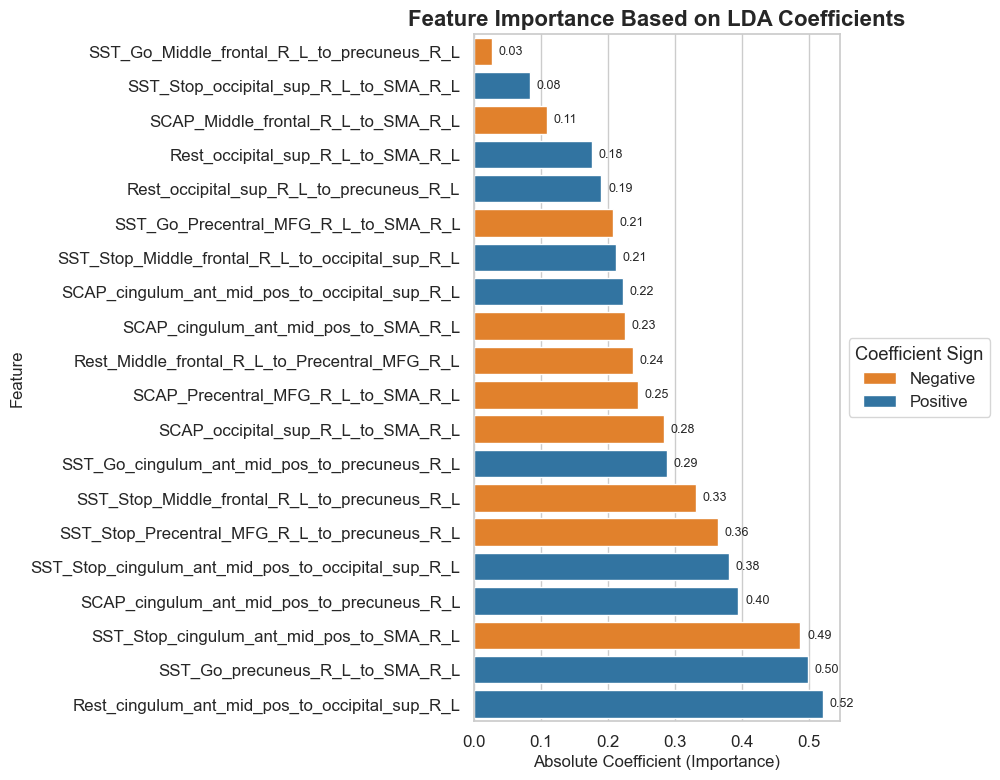

In [10]:
# === FEATURE IMPORTANCE FROM LDA COEFFICIENTS (Improved Plot) ===
lda_model = best_model.named_steps['lda']  # Extract trained LDA
coefficients = lda_model.coef_[0]          # Use signed coefficients
abs_coefficients = np.abs(coefficients)    # For importance
feature_names = selected_features

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs_coefficients,
    'Sign': ['Positive' if c > 0 else 'Negative' for c in coefficients]
}).sort_values(by='Importance', ascending=True)

# Plot settings
sns.set(style="whitegrid", font_scale=1.1)
palette = {'Positive': '#1f77b4', 'Negative': '#ff7f0e'}

# Plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=coef_df, x='Importance', y='Feature', hue='Sign', dodge=False, palette=palette)

# Add value labels
for i, (value, feature) in enumerate(zip(coef_df['Importance'], coef_df['Feature'])):
    ax.text(value + 0.01, i, f'{value:.2f}', va='center', fontsize=9)

# Styling
plt.title('Feature Importance Based on LDA Coefficients', fontsize=16, weight='bold')
plt.xlabel('Absolute Coefficient (Importance)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='Coefficient Sign', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for legend
plt.show()
